### Mandelbrot with Numba + CUDA on Google Colab

This is a extended and modified version of Nvidias Numba example (Mandelbrot) found at: https://developer.nvidia.com/blog/numba-python-cuda-acceleration/

Update the Intel threading library (tbb) used on Colab with Numba to parallelize on the CPU (and not OpenMP).

In [64]:
!echo "deb http://cz.archive.ubuntu.com/ubuntu focal main universe" | sudo tee -a /etc/apt/sources.list
!sudo apt update &> /dev/null
!sudo apt install libtbb-dev &> /dev/null

deb http://cz.archive.ubuntu.com/ubuntu focal main universe


In [2]:
pip install --upgrade tbb

     |████████████████████████████████| 3.9MB 29.7MB/s 


### Init and helper functions

In [87]:
#Make all the imports
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

from numba import vectorize, float32, vectorize, jit, prange


# Helper for timer
def timer_inner(f,*args):
    start = timer()
    f(*args)
    return timer() - start


# Execute a function multiple times and print init overhead and mean exec time
def time_function(f, *args):
    name = getattr(f, "__name__", "CUDA function with no name")
    print(f"First execution time of {name} is: {timer_inner(f, *args)}s.")
    t_mean = np.mean([timer_inner(f, *args) for _ in range(10)])
    print(f"Mean execution time of {name} is: {t_mean}s.")


# Helper function to check for AVX calls
def find_avx_instr(func, sig=0):
    count = 0
    for l in func.inspect_asm(func.signatures[sig]).split('\n'):
        if "subp" in l:
            count += 1
            print(l)
            if count >= 5:  # Only print 5 instructions
                return
    print('No instructions found')
  

### Numba basics
Read more here: http://numba.pydata.org/ :)

We use a very basic example to calculate the squeare difference of two vectors. You have to slighlty adapt the code to perform different compiled versions of it.


In [72]:
# This are our input vectors
SIZE = 1<<22
x32 = np.linspace(1, 2, SIZE, dtype=np.float32)
y32 = np.linspace(2, 3, SIZE, dtype=np.float32)
# In case you need an output vector (instead of just return it) use this one:
result32 = np.zeros(SIZE, dtype=np.float32)

In [77]:
#100% Python code using a loop to iterate over the items
def sqdiff_python(x, y, result):
    for i in range(SIZE):
      result[i] = (x[i] - y[i])**2
    return result32

time_function(sqdiff_python, x32, y32, result32)

First execution time of sqdiff_python is: 12.07170443599989s.
Mean execution time of sqdiff_python is: 11.870287473700046s.


**ToDo:** It is your turn! Make this faster by using Numba. First of all, make a just-in-time compilation and use nopython=True as this is the default now a days.

In [79]:
# Use Numba jit
@jit(nopython=True)
def sqdiff_jit(x, y, result):
    for i in range(SIZE):
      result[i] = (x[i] - y[i])**2
    return result32

time_function(sqdiff_jit, x32, y32, result32)

First execution time of sqdiff_jit is: 0.13626263500009372s.
Mean execution time of sqdiff_jit is: 0.003797398500046256s.


Sweet! 1 Line of code and a speedup of more than 1000x!

But you already know that it is stupid to iterate in Python on numpy arrays... So let us see how numpy compiled C code performs vs JIT compiled LLVM code. 

In [80]:
def sqdiff_numpy(x, y):
    return (x - y)**2

time_function(sqdiff_numpy, x32, y32)

First execution time of sqdiff_numpy is: 0.011393746999601717s.
Mean execution time of sqdiff_numpy is: 0.005954421199930948s.


On par! Do you know that you compiled the Python code using AVX calls?

In [81]:
find_avx_instr(sqdiff_jit)

	vsubps	(%rbp,%rax,4), %ymm0, %ymm0
	vsubps	32(%rbp,%rax,4), %ymm1, %ymm1
	vsubps	64(%rbp,%rax,4), %ymm2, %ymm2
	vsubps	96(%rbp,%rax,4), %ymm3, %ymm3
	vsubps	128(%rbp,%rax,4), %ymm0, %ymm0


**ToDo:** Next up, do the same thing again but this time use a parallel CPU version. Use nopython=True, parallel=True, nogil=True, fastmath=True as well as replace the range() with prage() from numba. This ensures that numba has no excuse in finding something to parallelize.

In [82]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def sqdiff_jit_parallel(x, y, result):
    for i in prange(SIZE):
      result[i] = (x[i] - y[i])**2
    return result32

time_function(sqdiff_jit_parallel, x32, y32, result32)

First execution time of sqdiff_jit_parallel is: 0.40626256900031876s.
Mean execution time of sqdiff_jit_parallel is: 0.003276805000132299s.


The speedup is not that good... Numba is just not really good at this, the overhead of the Threads is rather big compared to the work and we only have 1 CPU core with Hyper-Threading enabled here :( By the way, here is another example of how to do this:


In [84]:
@vectorize(['float32(float32,float32)'], target='parallel')
def sqdiff_vectorize_cpu(x, y):
    return (x - y)**2
    
time_function(sqdiff_vectorize_cpu, x32, y32)

First execution time of sqdiff_vectorize_cpu is: 0.004042712000227766s.
Mean execution time of sqdiff_vectorize_cpu is: 0.0030447051000010105s.


In [91]:
# If you want to see what numba tries to parallelize and to optimize, 
# have a look at this:
sqdiff_jit_parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function sqdiff_jit_parallel, <ipython-
input-83-ead4e5175e58> (1)  


Parallel loop listing for  Function sqdiff_jit_parallel, <ipython-input-83-ead4e5175e58> (1) 
-----------------------------------------------------------------|loop #ID
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)    | 
def sqdiff_jit_parallel(x, y, result):                           | 
    return (x - y)**2--------------------------------------------| #4
--------------------------------- Fusing loops ---------------------------------
Attempting fusion of parallel loops (combines loops with similar properties)...
----------------------------- Before Optimisation ------------------------------
--------------------------------------------------------------------------------
------------------------------ After Optimisation ------------------------------
Parallel structure is already optimal.
--------------------------------------------------------------------------

**ToDo:** Next up, throw this to the GPU. What do you expect? Use the above @vectorize decorator and choose another target.

In [88]:
@vectorize(['float32(float32,float32)'], target='cuda')
def sqdiff_vectorize_gpu(x, y):
    return (x - y)**2
    
time_function(sqdiff_vectorize_gpu, x32, y32)

First execution time of CUDA function with no name is: 0.15567051800007903s.
Mean execution time of CUDA function with no name is: 0.014915447999828756s.


I hope you expected this. The overhead is just too big. Nevertheless we just saw how easy it is to pit some numpy stuff to the GPU. But let us do some more adavanced stuff.

### Mandelbrot calculation
The mandel function performs the Mandelbrot set calculation for a given (x,y) position on the imaginary plane. It returns the number of iterations before the computation "escapes".


create_fractal iterates over all the pixels in the image, computing the complex coordinates from the pixel coordinates, and calls the mandel function at each pixel. The return value of mandel is used to color the pixel.


Next we create a 1536x1024 pixel image as a numpy array of bytes. We then call create_fractal with appropriate coordinates to fit the whole mandelbrot set.

First execution time of create_fractal_python is: 4.603057821999755s.
Mean execution time of create_fractal_python is: 4.620661572999961s.


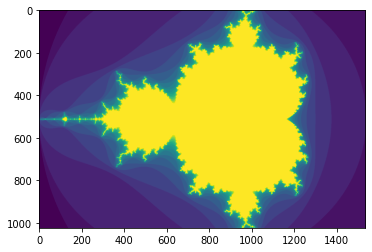

In [92]:
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

def create_fractal_python(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color


image = np.zeros((1024, 1536), dtype = np.uint8)
time_function(create_fractal_python, -2.0, 1.0, -1.0, 1.0, image, 20)
imshow(image)
show()

**ToDo:** Your turn! Make it faster using Numba and JIT compile both functions.

First execution time of create_fractal_jit is: 0.3588434210005289s.
Mean execution time of create_fractal_jit is: 0.05218968739991396s.


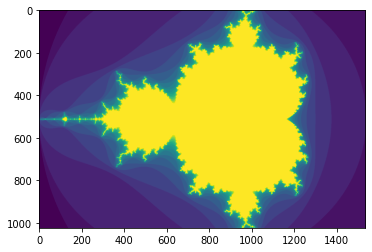

In [93]:
@jit(nopython=True)
def mandel_jit(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit(nopython=True)
def create_fractal_jit(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel_jit(real, imag, iters)
      image[y, x] = color


image = np.zeros((1024, 1536), dtype = np.uint8)
time_function(create_fractal_jit, -2.0, 1.0, -1.0, 1.0, image, 20)
imshow(image)
show()

**ToDo:** All-In! Write a CUDA kernel using Numba to speed this up.

Numba provides the familiar CUDA threadIdx, blockIdx, blockDim and gridDim intrinsics, as well as a grid() convenience function which evaluates to blockDim * blockIdx + threadIdx.

Our example juse needs a minor modification to compute a grid-size stride for the x and y ranges, since we will have many threads running in parallel. We just add these three lines:

startX, startY = cuda.grid(2)
gridX = cuda.gridDim.x * cuda.blockDim.x;
gridY = cuda.gridDim.y * cuda.blockDim.y;

And we modify the range in the x loop to use range(startX, width, gridX) (and likewise for the y loop).

We decorate the function with @cuda.jit. Numba will infer the type signature from the invocation of the function.

In [95]:
# We can reuse the first madel function and just recompile it using CUDA
mandel_gpu = cuda.jit(device=True)(mandel)

# Extend the fractal function
@cuda.jit
def create_fractal_gpu(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

**Memory transfer**
Numba provides the cuda.to_device() function to copy a Numpy array to the GPU.

`d_image = cuda.to_device(image)`

The return value (d_image) is of type DeviceNDArray, which is a subclass of numpy.ndarray, and provides the to_host() function to copy the array back from GPU to CPU memory

`d_image.to_host()`

**Launching Kernels**

To launch a kernel on the GPU, we must configure it, specifying the size of the grid in blocks, and the size of each thread block. For a 2D image calculation like the Mandelbrot set, we use a 2D grid of 2D blocks. We'll use blocks of 32x8 threads, and launch 32x16 of them in a 2D grid so that we have plenty of blocks to occupy all of the multiprocessors on the GPU.

Putting this all together, we launch the kernel like this.

First execution time of cuda_wrapper_fractal is: 0.2559904150002694s.
Mean execution time of cuda_wrapper_fractal is: 0.00574567069998011s.


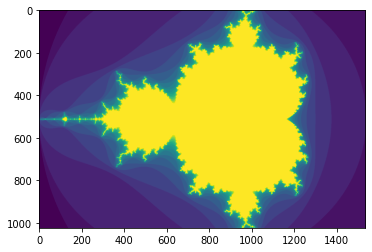

In [96]:
def cuda_wrapper_fractal(image):
  d_image = cuda.to_device(image)
  create_fractal_gpu[(32,16), (32, 8)](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
  d_image.to_host()

image = np.zeros((1024, 1536), dtype = np.uint8)
time_function(cuda_wrapper_fractal,image)
imshow(image)
show()

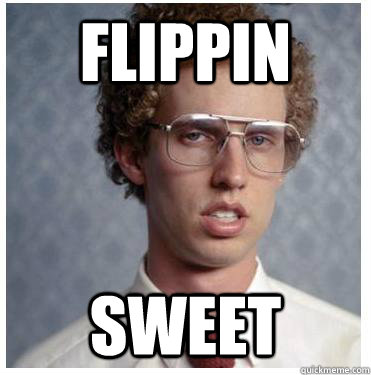